In [56]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from plotnine import *

In [57]:
df = pd.read_csv(os.path.join('.data', 'train.csv'))
print(df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [58]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [59]:
# df['PassengerId'] = df['PassengerId'].astype('object')
# df['Sex'] = df['Sex'].astype('category')
# df['Survived'] = df['Survived'].astype('category')
# df['Pclass'] = df['Pclass'].astype('category')
# df['SibSp'] = df['SibSp'].astype('category')
# df['Parch'] = df['Parch'].astype('category')

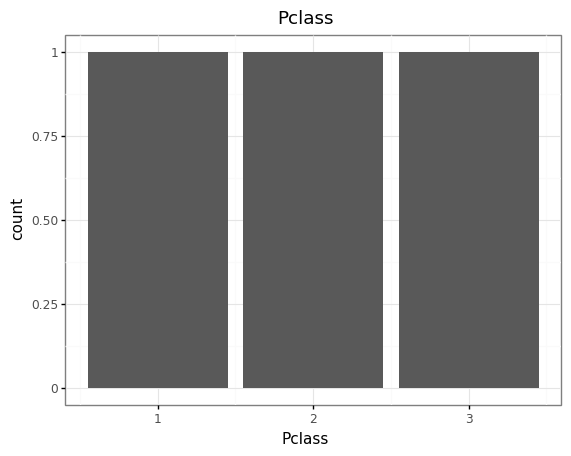

<ggplot: (8753652886291)>
3    491
1    216
2    184
Name: Pclass, dtype: int64
nan-sum: 0
-----------------------------------------------------


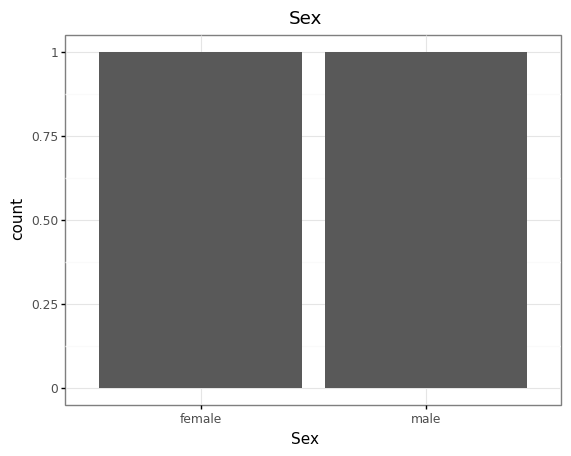

<ggplot: (8753653800536)>
male      577
female    314
Name: Sex, dtype: int64
nan-sum: 0
-----------------------------------------------------


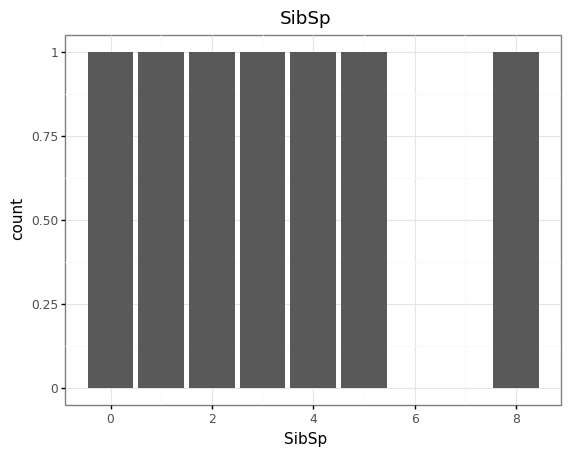

<ggplot: (8753653493179)>
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64
nan-sum: 0
-----------------------------------------------------


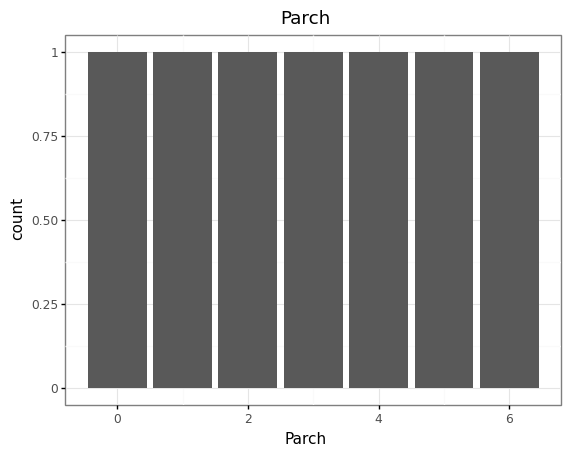

<ggplot: (8753654504337)>
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64
nan-sum: 0
-----------------------------------------------------


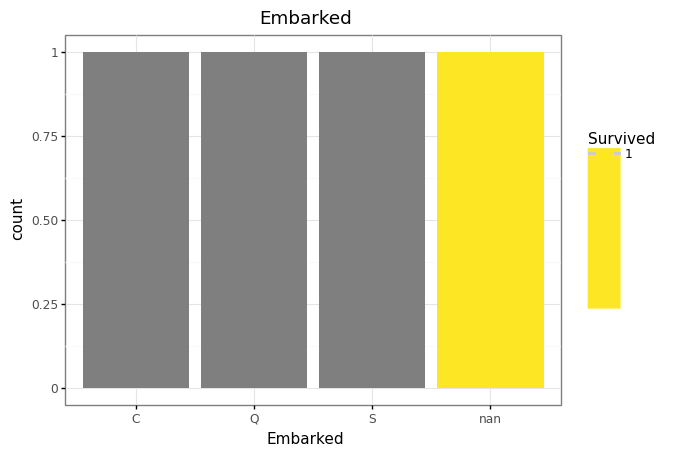

<ggplot: (8753653106728)>
S    644
C    168
Q     77
Name: Embarked, dtype: int64
nan-sum: 2
-----------------------------------------------------


In [60]:
for col in df.columns:
    if (df[col].dtype!='float64' and col not in ['PassengerId', 'Name', 'Survived', 'Ticket', 'Cabin']):
        print(
            ggplot(df) +\
            aes(x = col, fill = 'Survived') +\
            geom_bar(position = 'fill') +\
            labs(title = col) +\
            theme_bw()
        )
        
        print(df[col].value_counts())
        print("nan-sum:", df[col].isnull().sum())
        print("-----------------------------------------------------")

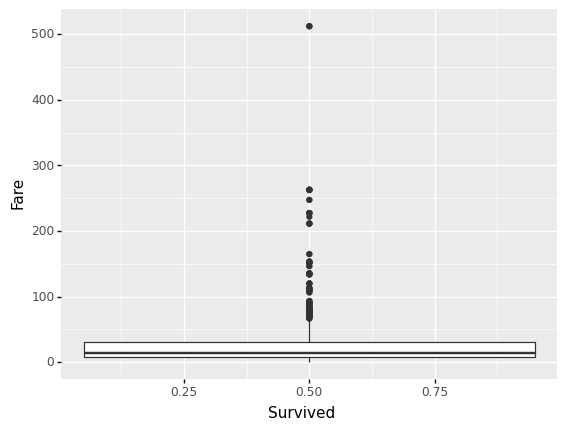

<ggplot: (8753652896669)>

In [61]:
# boxplot of Fare
ggplot(df, aes(x = "Survived", y = "Fare")) +\
    geom_boxplot()

In [62]:
# Ticket
ticket_counts = pd.DataFrame(df['Ticket'].value_counts()).reset_index()
ticket_counts.columns = ['Ticket', 'ticket_count']

df = pd.merge(df, ticket_counts, on='Ticket')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,ticket_count
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,138,0,1,"Futrelle, Mr. Jacques Heath",male,37.0,1,0,113803,53.1000,C123,S,2


In [8]:
# Cabin
cabin_counts = pd.DataFrame(df['Cabin'].value_counts()).reset_index()
cabin_counts.columns = ['Cabin', 'cabin_count']

df = pd.merge(df, cabin_counts, on='Cabin')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,ticket_count,cabin_count
0,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1
1,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,2
2,138,0,1,"Futrelle, Mr. Jacques Heath",male,37.0,1,0,113803,53.1000,C123,S,2,2
3,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,1,1
4,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,2,4


In [71]:
df_m = df[~df['Embarked'].isnull()].copy()
label_encoder = LabelEncoder()

df_m['Sex'] = sex_le = label_encoder.fit_transform(df_m['Sex'])
df_m['Embarked'] = embarked_le = label_encoder.fit_transform(df_m['Embarked'])

In [72]:
df_xage = df_m[df_m['Age'].isna()].reset_index()
df_xage['age_predicted'] = 1

df_age = df_m[~df_m['Age'].isna()].reset_index()
df_age['age_predicted'] = 0

In [67]:
age_lin = Lasso().fit(
    df_age[['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']]
    , df_age['Age']
)

pred_age = age_lin.predict(df_xage[['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']])
df_xage['Age'].update(pred_age)

In [ ]:
# Now age has been processed, need to reclassify other vairables

In [85]:
df_m = df_age.append(df_xage, ignore_index=True)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(
    df_m.loc[:, (df_m.columns != 'Survived') & (df_m.columns.isin(['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Age']))]
    , df_m['Survived']
)

In [87]:
dt = DecisionTreeClassifier().fit(X_train, y_train)
score = dt.score(X_train, y_train)
pred = dt.predict(X_test)

print(score, "\n")
print(confusion_matrix(y_test, pred), "\n")
print(classification_report(y_test, pred))

1.0 

[[ 9  8]
 [ 7 22]] 

              precision    recall  f1-score   support

           0       0.56      0.53      0.55        17
           1       0.73      0.76      0.75        29

    accuracy                           0.67        46
   macro avg       0.65      0.64      0.65        46
weighted avg       0.67      0.67      0.67        46



In [17]:
#--- Niceeeee ------
